In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

In [ ]:
!wget https://github.com/AndresLDF/ML-Zoomcamp-Capstone2-BitCoinPricePrediction/raw/main/Datasets/BCP_extended_dataframe.csv
df = pd.read_csv("BCP_extended_dataframe.csv")

--2024-01-22 13:17:15--  https://github.com/AndresLDF/ML-Zoomcamp-Capstone2-BitCoinPricePrediction/raw/main/Datasets/BCP_extended_dataframe.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AndresLDF/ML-Zoomcamp-Capstone2-BitCoinPricePrediction/main/Datasets/BCP_extended_dataframe.csv [following]
--2024-01-22 13:17:15--  https://raw.githubusercontent.com/AndresLDF/ML-Zoomcamp-Capstone2-BitCoinPricePrediction/main/Datasets/BCP_extended_dataframe.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218589 (213K) [text/plain]
Saving to: ‘BCP_extended_dataframe.csv’

BCP_extended_datafr 100%[======

In [ ]:
df.head()

,unix,open,volume_btc,volume_eur,7_days_a,30_days_a,90_days_a,next_day_value,next_week_value
0,1472947200,532.05,83410.07,154.84,0.12,-0.69,-1.06,539.0,548.0
1,1473033600,537.83,194358.24,362.37,1.85,-0.57,-1.13,541.0,543.0
2,1473120000,539.26,204407.28,377.54,3.84,-0.40,-1.19,545.0,543.0
3,1473206400,542.80,193789.48,356.05,5.10,-0.17,-1.25,552.0,543.0
4,1473292800,547.69,234580.43,422.91,6.09,0.11,-1.31,556.0,543.0


## Data preparation

Neural networks may have issue handling large number, because of this an personalization is done

In [ ]:
df["next_day_value"] = df["next_day_value"]/df["open"]-1
df["next_week_value"] = df["next_week_value"]/df["open"]-1
df["volume_btc"] = df["volume_btc"]/(df["open"]*100)
df["volume_eur"] = df["volume_eur"]/df["open"]


In [ ]:
df

,unix,open,volume_btc,volume_eur,7_days_a,30_days_a,90_days_a,next_day_value,next_week_value
0,1472947200,532.05,1.567711,0.291025,0.12,-0.69,-1.06,0.013063,0.029978
1,1473033600,537.83,3.613749,0.673763,1.85,-0.57,-1.13,0.005894,0.009613
2,1473120000,539.26,3.790514,0.700108,3.84,-0.40,-1.19,0.010644,0.006935
3,1473206400,542.80,3.570182,0.655951,5.10,-0.17,-1.25,0.016949,0.000368
4,1473292800,547.69,4.283088,0.772170,6.09,0.11,-1.31,0.015173,-0.008563
...,...,...,...,...,...,...,...,...,...
2663,1703030400,38515.00,0.000137,546.336886,-47.00,245.15,183.70,0.035519,0.008308
2664,1703116800,39891.00,0.000097,388.483300,-123.11,235.62,183.82,0.000978,-0.026472
2665,1703203200,39875.00,0.000076,305.191573,88.04,232.69,184.32,0.000803,-0.037693
2666,1703289600,40000.00,0.000029,115.056550,242.11,216.90,184.60,-0.012150,-0.043400


In [ ]:
dfX = df.iloc[:,1:-2]
dfy = df.iloc[:,-2:]

In [ ]:
dfX_fulltrain, dfX_test, dfy_fulltrain, dfy_test  = train_test_split(dfX, dfy, test_size=0.2, random_state= 4)
dfX_train, dfX_eval, dfy_train, dfy_eval = train_test_split(dfX_fulltrain, dfy_fulltrain, test_size=0.25, random_state= 4)
dfX_fulltrain = dfX_fulltrain.reset_index(drop = True)
dfX_test = dfX_test.reset_index(drop = True)
dfy_fulltrain = dfX_fulltrain.reset_index(drop = True)
dfy_test = dfy_test.reset_index(drop = True)
dfX_train = dfX_train.reset_index(drop = True)
dfX_eval = dfX_eval.reset_index(drop = True)
dfy_train = dfy_train.reset_index(drop = True)
dfy_eval = dfy_eval.reset_index(drop = True)

dfX_test.shape, dfy_test.shape, dfX_train.shape, dfy_train.shape, dfX_eval.shape, dfy_eval.shape

((534, 6), (534, 2), (1600, 6), (1600, 2), (534, 6), (534, 2))

In [ ]:
def model_evaluator(dfy_eval, y_eval_pred, result_indentificator_string, aceptable_error=3):
  if result_indentificator_string == "next_week_value":
    individual_errors = (dfy_eval[result_indentificator_string] - y_eval_pred[:,1])/dfy_eval[result_indentificator_string]*100
  elif result_indentificator_string == "next_day_value":
    individual_errors = (dfy_eval[result_indentificator_string] - y_eval_pred[:,0])/dfy_eval[result_indentificator_string]*100
  elif result_indentificator_string == "one_value":
    individual_errors = (dfy_eval - y_eval_pred)/dfy_eval*100
  else:
    raise ValueError("Please enter a valid value for the argument result_indentificator_string")
  acceptabe_predictins_7d = (np.abs(individual_errors)<=aceptable_error).sum()
  moderate_unacceptable_predictins_7d=(np.abs(individual_errors)>aceptable_error).sum() - (np.abs(individual_errors)>(aceptable_error*5/3)).sum()
  highly_unacceptable_predictions_7d=(np.abs(individual_errors)>=(aceptable_error*5/3)).sum() - (np.abs(individual_errors)>20).sum()
  blatant_unacceptable_predictions_7d = (np.abs(individual_errors)>20).sum()
  total_unacceptable_predictions = (np.abs(individual_errors)>aceptable_error).sum()
  acceptable_ratio = acceptabe_predictins_7d/(total_unacceptable_predictions+acceptabe_predictins_7d)
  acceptable_ratio = np.round(acceptable_ratio,2)
  acceptable_weighted_ratio = acceptabe_predictins_7d/(moderate_unacceptable_predictins_7d+(highly_unacceptable_predictions_7d*2)+(blatant_unacceptable_predictions_7d*4)+acceptabe_predictins_7d)
  acceptable_weighted_ratio = np.round(acceptable_weighted_ratio,2)
  #print(f"The Acceptable Ratio (accuracy) is {acceptable_ratio}")
  #print(f"the Weighted Ratio is {acceptable_weighted_ratio}")
  return individual_errors, acceptable_ratio, acceptable_weighted_ratio


In [ ]:
def model_create(n_inputs, n_outputs, learning_rate=0.01, drop_rate=0.2):

    optimizer = Adam(learning_rate=learning_rate)

    model = Sequential()
    model.add(Dense(200, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(500, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(300, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(300, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(n_outputs))
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def model_train (model, df_train, y_train, epochs_n):
    training_scores = []
    history = model.fit(df_train, y_train, verbose = 0, epochs=epochs_n)
    training_score = history.history['loss'][0]
    return training_score, model

def model_eval(df_eval, y_eval, aceptable_error):
    y_eval_pred = model.predict(df_eval)
    #rmse = mean_squared_error(y_eval, y_eval_pred, squared=False)
    individual_errors, acceptable_ratio, acceptable_weighted_ratio = model_evaluator(y_eval, y_eval_pred, "one_value", aceptable_error=aceptable_error)
    return acceptable_ratio, acceptable_weighted_ratio, rsm



In [ ]:
def train_eval(dfX_train, dfy_train, dfX_eval, dfy_eval, learning_rate=0.01, drop_rate=0.2, epochs_n=200):
  n_inputs = len(dfX_train.columns)-1
  n_outputs = len(dfy_train.columns)
  model = model_create(n_inputs, n_outputs)
  score, trainde_model = model_train(model, dfX_train.iloc[:,1:], dfy_train["next_week_value"], epochs_n)
  y_eval_pred = trainde_model.predict(dfX_eval.iloc[:,1:])
  print(y_eval_pred)

  eval_pred_7d=(y_eval_pred[:,1]+1)*dfX_eval["open"]
  eval_real_7d=(dfy_eval["next_week_value"]+1)*dfX_eval["open"]
  individual_errors_7d, acceptable_ratio_7d, acceptable_weighted_ratio_7d =  model_evaluator(eval_real_7d, eval_pred_7d.values, "one_value", aceptable_error=3)

  eval_pred_1d=(y_eval_pred[:,0]+1)*dfX_eval["open"]
  eval_real_1d=(dfy_eval["next_day_value"]+1)*dfX_eval["open"]
  individual_errors_1d, acceptable_ratio_1d, acceptable_weighted_ratio_1d =  model_evaluator(eval_real_1d, eval_pred_1d.values, "one_value", aceptable_error=1.5)

  return acceptable_ratio_7d, acceptable_weighted_ratio_7d, acceptable_ratio_1d, acceptable_weighted_ratio_1d


In [ ]:
#acceptable_ratio_7d, acceptable_weighted_ratio_7d, acceptable_ratio_1d, acceptable_weighted_ratio_1d = train_eval(dfX_train, dfy_train, dfX_eval, dfy_eval)

In [ ]:
#acceptable_ratio_7d, acceptable_weighted_ratio_7d, acceptable_ratio_1d, acceptable_weighted_ratio_1d

In [ ]:
epochs_n_list = [100, 200, 400, 500, 600, 800]
learning_rate_list = [1, 0.5, 0.1, 0.01]
results_columns = ["epochs_n", "learning_rate", "acceptable_ratio_7d", "acceptable_weighted_ratio_7d", "acceptable_ratio_1d", "acceptable_weighted_ratio_1d"]
results_df = pd.DataFrame(columns=results_columns)

for epochs_n in epochs_n_list:
  for learning_rate in learning_rate_list:
    acceptable_ratio_7d, acceptable_weighted_ratio_7d, acceptable_ratio_1d, acceptable_weighted_ratio_1d = train_eval(dfX_train, dfy_train, dfX_eval, dfy_eval, learning_rate=learning_rate, epochs_n=epochs_n)
    new_row = [epochs_n, learning_rate, acceptable_ratio_7d, acceptable_weighted_ratio_7d, acceptable_ratio_1d, acceptable_weighted_ratio_1d]
    new_row_df = pd.DataFrame([new_row], columns=results_columns)
    results_df = pd.concat([results_df, new_row_df], ignore_index=True)


17/17 [==============================] - 0s 3ms/step
[[0.01466838 0.02015759]
 [0.01466838 0.02015759]
 [0.01466838 0.02015759]
 ...
 [0.01466838 0.02015759]
 [0.01466838 0.02015759]
 [0.01466838 0.02015759]]
17/17 [==============================] - 0s 2ms/step
[[0.01955928 0.01974646]
 [0.01955928 0.01974646]
 [0.01955928 0.01974646]
 ...
 [0.01955928 0.01974646]
 [0.01955928 0.01974646]
 [0.01955928 0.01974646]]
17/17 [==============================] - 0s 2ms/step
[[0.00933534 0.0239553 ]
 [0.00933534 0.0239553 ]
 [0.00933534 0.0239553 ]
 ...
 [0.00933534 0.0239553 ]
 [0.00933534 0.0239553 ]
 [0.00933534 0.0239553 ]]
17/17 [==============================] - 0s 3ms/step
[[0.01742294 0.02117641]
 [0.01742294 0.02117641]
 [0.01742294 0.02117641]
 ...
 [0.01742294 0.02117641]
 [0.01742294 0.02117641]
 [0.01742294 0.02117641]]
17/17 [==============================] - 0s 3ms/step
[[0.02508486 0.02297559]
 [0.02508486 0.02297559]
 [0.02508486 0.02297559]
 ...
 [0.02508486 0.02297559]
 [0.02

In [ ]:
results_df

,epochs_n,learning_rate,acceptable_ratio_7d,acceptable_weighted_ratio_7d,acceptable_ratio_1d,acceptable_weighted_ratio_1d
0,100,1,0.32,0.19,0.38,0.26
1,100,0.5,0.31,0.19,0.31,0.21
2,100,0.1,0.30,0.18,0.43,0.30
3,100,0.01,0.31,0.19,0.34,0.23
4,200,1,0.31,0.19,0.24,0.15
5,200,0.5,0.34,0.21,0.38,0.26
6,200,0.1,0.32,0.20,0.38,0.27
7,200,0.01,0.32,0.20,0.38,0.26
8,400,1,0.32,0.20,0.41,0.29
9,400,0.5,0.32,0.20,0.36,0.25


<ipython-input-16-39d7a896968d>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = results_df.pivot("epochs_n", "learning_rate", "acceptable_weighted_ratio_1d")
<ipython-input-16-39d7a896968d>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results_df.pivot("epochs_n", "learning_rate", "acceptable_weighted_ratio_1d")
<ipython-input-16-39d7a896968d>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results_df.pivot("epochs_n", "learning_rate", "acceptable_weighted_ratio_1d")


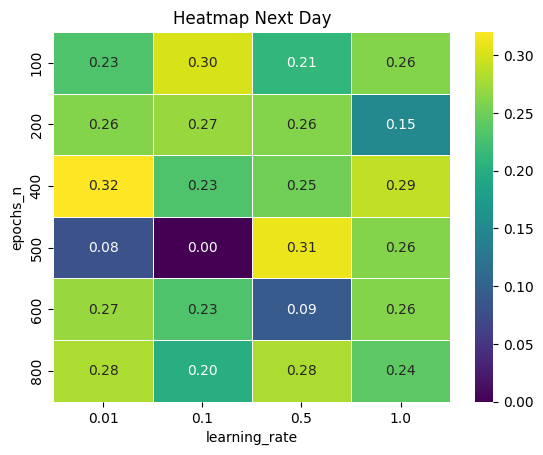

<ipython-input-16-39d7a896968d>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = results_df.pivot("epochs_n", "learning_rate", "acceptable_weighted_ratio_7d")
<ipython-input-16-39d7a896968d>:9: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results_df.pivot("epochs_n", "learning_rate", "acceptable_weighted_ratio_7d")
<ipython-input-16-39d7a896968d>:9: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results_df.pivot("epochs_n", "learning_rate", "acceptable_weighted_ratio_7d")


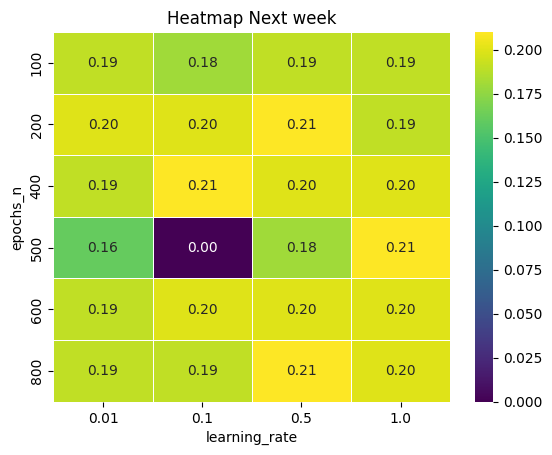

In [ ]:

heatmap_data = results_df.pivot("epochs_n", "learning_rate", "acceptable_weighted_ratio_1d")
# Create a heatmap
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title(f"Heatmap Next Day")
plt.xlabel("learning_rate")
plt.ylabel("epochs_n")
plt.show()

heatmap_data = results_df.pivot("epochs_n", "learning_rate", "acceptable_weighted_ratio_7d")
# Create a heatmap
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title(f"Heatmap Next week")
plt.xlabel("learning_rate")
plt.ylabel("epochs_n")
plt.show()


From the results we can see:
* Results are low compared to Tree models
* The 1 day results and 7 day results should have each one its own neural network and be calculated by separate
